# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
# import basic libraries
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt

#import clustering libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from scipy import stats

# import custom functions
import importlib
loader = importlib.machinery.SourceFileLoader(fullname='module',path='analysis_model/data_analysis_model.py')
handle = loader.load_module('module')

% matplotlib inline

#read in the raw json data files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 1. Data Pre-processing

In [2]:
# clean and process the raw data for ease of analysis later
df_portfolio_clean = handle.clean_portfolio(portfolio)
df_profile_clean = handle.clean_profile(profile)
df_transcript_clean = handle.clean_transcript(transcript)

# 2. Data Analysis

## A. General Analysis

In [3]:
print("This data simulation is ran for about {} days".format(df_transcript_clean.time.max()/24))

This data simulation is ran for about 29.75 days


In [4]:
print("There are total of {} transactions generated from {} customer profiles and {} offer portfolios."\
     .format(df_transcript_clean.shape[0],df_profile_clean.shape[0],df_portfolio_clean.shape[0]))

There are total of 306534 transactions generated from 17000 customer profiles and 10 offer portfolios.


## B.  Prepare and Merge datasets of details analysis

In [5]:
# merge all the data frames into single dataset for analysis
df_merge = df_transcript_clean.merge(df_portfolio_clean, on='offer_id', how='left')
df_merge = df_merge.merge(df_profile_clean, on='customer_id', how='left')

# filter only complete profile = 1 transactions
df_merge_complete = df_merge[df_merge['complete_profile'] == 1]

# create df for transactions with amount for further analysis
df_mc_transactions = df_merge_complete[df_merge_complete['event_transaction'] == 1]

# count the number & total amount purchase by customer
df_customer_mct = df_mc_transactions.groupby(['customer_id'], as_index=False) \
                                    .agg({'event_transaction': 'count', 'amount': 'sum'}) \
                                    .rename(columns={'event_transaction':'cnt_transaction', 'amount': 'sum_amount'})

# create df for offer related transcripts for further analysis
df_mc_offer = df_merge_complete[df_merge_complete['event_transaction'] == 0]

# analyze per customer, what is the response for different type of offers 
df_customer_mco = df_mc_offer.groupby(['customer_id', 'offer_label'], as_index=False) \
                              .agg({'event_offer_received': 'sum', 'event_offer_viewed': 'sum', 'event_offer_completed': 'sum' })
df_customer_mco.rename(columns={'event_offer_received':'cnt_received',
                          'event_offer_viewed':'cnt_viewed',
                          'event_offer_completed':'cnt_completed'}, 
                       inplace=True)

# pull the list of unique customer id from the profile clean dataframe
df_customer = pd.DataFrame(df_profile_clean[['customer_id', 'gender', 'gender_cat', 'age_cat', 'income_cat']][df_profile_clean.complete_profile == 1])

# sum the # of diff offers activities across diff offer type per customer
df_cust_mco_sum = df_customer_mco[['customer_id','cnt_received','cnt_viewed','cnt_completed']].groupby('customer_id').sum()

# merge the list of customers with the # of offer transactions per customer id 
df_cust_mcot_sum = df_customer.merge(df_cust_mco_sum, how='left', on='customer_id')

# merge the list of customers with the # of purchase transactions & total amount per customer id 
df_cust_mcot_sum = df_cust_mcot_sum.merge(df_customer_mct, how='left', on='customer_id')

# calculate the average purchase
df_cust_mcot_sum['avg_purchase'] = (df_cust_mcot_sum['sum_amount']/df_cust_mcot_sum['cnt_transaction']).round(2)

# fillna with 0
df_cust_mcot_sum.fillna(value=0, inplace=True)

df_cust_mcot_sum.shape 

(14825, 11)

## C. Customer Analysis

### i. Customer Demographics Data Distribution by gender, age, income

In [6]:
# let's look at the customer data distribution by gender, age_cat and income_cat
df_gender = df_merge.groupby(['gender']).count()['customer_id']
df_age = df_merge.groupby(['age_cat']).count()['customer_id']
df_income = df_merge.groupby(['income_cat']).count()['customer_id']

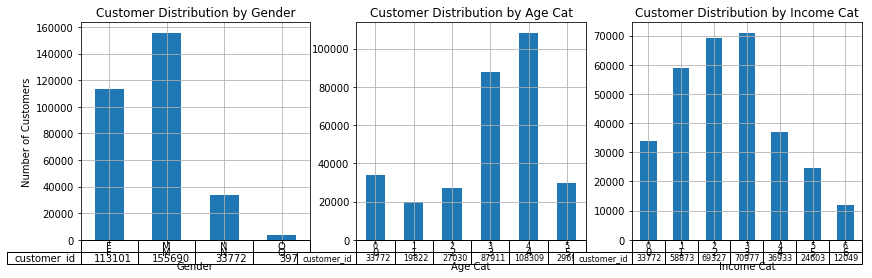

In [7]:
# plot graph for customer data distribution by categories
handle.plt_data(df_gender, subplot=131, ylabel='Number of Customers', xlabel='Gender', title='Customer Distribution by Gender')
handle.plt_data(df_age, subplot=132, xlabel='Age Cat', new_fig=False, title='Customer Distribution by Age Cat')
handle.plt_data(df_income, subplot=133, xlabel='Income Cat', new_fig=False, title='Customer Distribution by Income Cat')

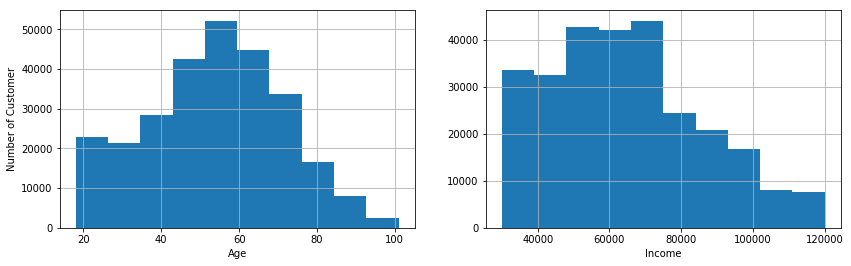

In [8]:
# let's look at the customer data distribution by age and income for those with complete_profile
# we are excluding incomplete customer profile with 0 income and invalid age to avoid scaling skew in graph plot
handle.plt_data(df_merge_complete['age'], subplot=121, plt_type='hist', bins=10, ylabel='Number of Customer', xlabel='Age')
handle.plt_data(df_merge_complete['income'], subplot=122, plt_type='hist', bins=10, xlabel='Income', new_fig=False)

1. We have 33,772 (11%) of transactions transacted by customers with invalid Gender (Gender=N), Age (Age_cat=0) & Income (Income_cat=0).
2. Male customers contributed to ~51% of the transactions, followed by Female (~37%) and others (~0.1%)
3. Age_cat 3 & 4 (Age ranging from 35-75) contributed to about 64% of total transactions.
4. ~65% of transactions falled between customers with Income_cat 1-3 (Income ranging from 30,000 - 75,000).
5. Overall, the distribution of transactions collected from the simulation looks pretty good.  There is no serious data imbalance that we need to address. 

### ii. Customer purchase analysis

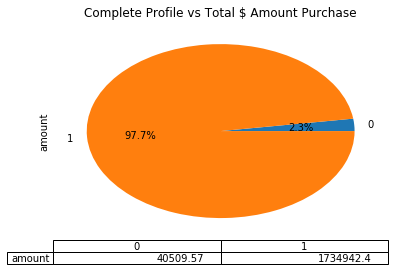

In [9]:
# spending for complete/incomplete profile
df_merge[df_merge['event_transaction'] == 1].groupby(['complete_profile']).sum()['amount'] \
                                            .plot(kind='pie', table=True, autopct='%1.1f%%'\
                                                  , title='Complete Profile vs Total $ Amount Purchase')


Based on the above analysis, since the amount of purchase generated from complete_profile=0 is relatively small (~2.3%), hence we can exclude it from our subsequent tasks for the purpose of this project.

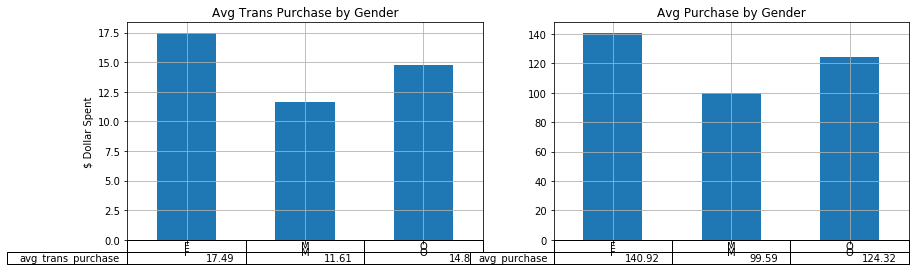

In [10]:
# Let's look at the customer purchase by gender
df_stats = df_cust_mcot_sum.groupby('gender')\
                           .agg({'cnt_transaction':'sum', 'sum_amount':'sum', 'customer_id':'count'})\
                           .rename(columns={'cnt_transaction':'sum_transaction',
                                            'sum_amount':'sum_amount',
                                            'customer_id':'cnt_customer'})
df_stats['avg_trans_purchase'] = (df_stats['sum_amount']/df_stats['sum_transaction']).round(2)
df_stats['avg_purchase'] = (df_stats['sum_amount']/df_stats['cnt_customer']).round(2)

handle.plt_data(df_stats['avg_trans_purchase'], subplot=121, ylabel='$ Dollar Spent', title='Avg Trans Purchase by Gender')
handle.plt_data(df_stats['avg_purchase'], subplot=122, title='Avg Purchase by Gender', new_fig=False)


1. Although Male customers dominant the total transactions by ~51%, however Female customers' spending power is higher where the average purchase in both categories above are ~50% higher than Male customers.
2. For Gender=O, although the average spending is higher than Male, however the transactions volume is only ~0.1%.  Hence it is insignificant to put focus on at this moment.

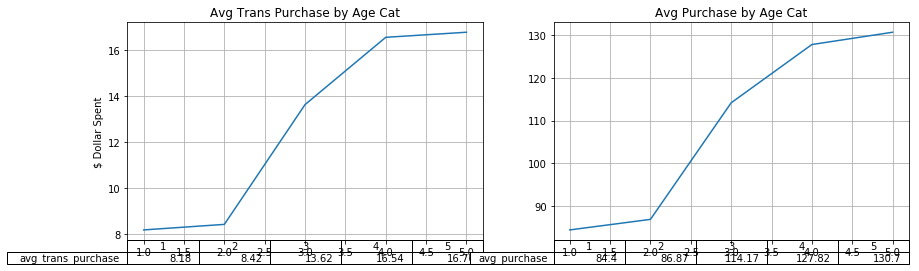

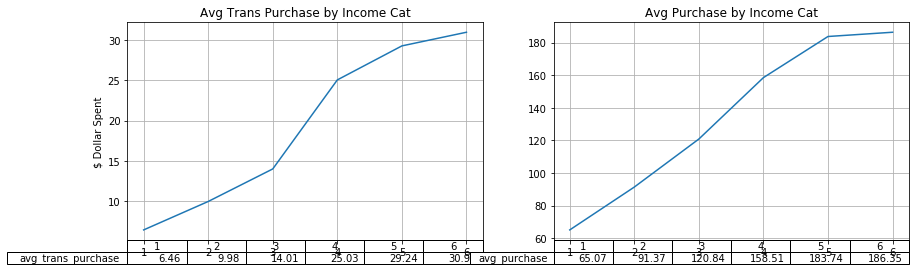

In [11]:
# Let's look at the customer purchase by age category
df_stats = df_cust_mcot_sum.groupby('age_cat')\
                           .agg({'cnt_transaction':'sum', 'sum_amount':'sum', 'customer_id':'count'})\
                           .rename(columns={'cnt_transaction':'sum_transaction',
                                            'sum_amount':'sum_amount',
                                            'customer_id':'cnt_customer'})
df_stats['avg_trans_purchase'] = (df_stats['sum_amount']/df_stats['sum_transaction']).round(2)
df_stats['avg_purchase'] = (df_stats['sum_amount']/df_stats['cnt_customer']).round(2)

handle.plt_data(df_stats['avg_trans_purchase'], kind='line', subplot=121, ylabel='$ Dollar Spent', title='Avg Trans Purchase by Age Cat')
handle.plt_data(df_stats['avg_purchase'], kind='line', subplot=122, title='Avg Purchase by Age Cat', new_fig=False)

# Let's look at the customer purchase by income category
df_stats = df_cust_mcot_sum.groupby('income_cat')\
                           .agg({'cnt_transaction':'sum', 'sum_amount':'sum', 'customer_id':'count'})\
                           .rename(columns={'cnt_transaction':'sum_transaction',
                                            'sum_amount':'sum_amount',
                                            'customer_id':'cnt_customer'})
df_stats['avg_trans_purchase'] = (df_stats['sum_amount']/df_stats['sum_transaction']).round(2)
df_stats['avg_purchase'] = (df_stats['sum_amount']/df_stats['cnt_customer']).round(2)

handle.plt_data(df_stats['avg_trans_purchase'], kind='line', subplot=121, ylabel='$ Dollar Spent', title='Avg Trans Purchase by Income Cat')
handle.plt_data(df_stats['avg_purchase'], kind='line', subplot=122, title='Avg Purchase by Income Cat', new_fig=False)

1. It is obviously shown that average purchase power increased significantly after age_cat=2 which is after age of 35.
2. For income cat, buying power increased by ~1.5x after income_cat=3 which is after $75,000.
3. There seems to be strong correlation between Age & Income which come generally in most cases.  The older you are and more experience you gained, you will earn higher income and able/willing to spend more in non-essential basic needs in life.  This is observed in the below corr analysis as well. 
    - 0.3 for age_cat & income_cat
    - 0.47 for avg_purchase & income_cat

In [33]:
corr = df_cust_mcot_sum.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,gender_cat,age_cat,income_cat,cnt_received,cnt_viewed,cnt_completed,cnt_transaction,sum_amount,avg_purchase,cluster
gender_cat,1,-0.13,-0.22,0.00025,-0.011,-0.17,0.047,-0.15,-0.17,0.1
age_cat,-0.13,1,0.3,-0.0034,0.051,0.12,-0.16,0.11,0.19,-0.18
income_cat,-0.22,0.3,1,-0.008,0.053,0.25,-0.26,0.31,0.47,-0.38
cnt_received,0.00025,-0.0034,-0.008,1,0.58,0.33,0.16,0.09,0.0015,-0.033
cnt_viewed,-0.011,0.051,0.053,0.58,1,0.4,0.21,0.2,0.096,-0.065
cnt_completed,-0.17,0.12,0.25,0.33,0.4,1,0.42,0.54,0.33,-0.28
cnt_transaction,0.047,-0.16,-0.26,0.16,0.21,0.42,1,0.35,-0.089,0.037
sum_amount,-0.15,0.11,0.31,0.09,0.2,0.54,0.35,1,0.76,-0.29
avg_purchase,-0.17,0.19,0.47,0.0015,0.096,0.33,-0.089,0.76,1,-0.38
cluster,0.1,-0.18,-0.38,-0.033,-0.065,-0.28,0.037,-0.29,-0.38,1


## D. Offer Analysis

### i. Offer Response vs Offer Type Analysis

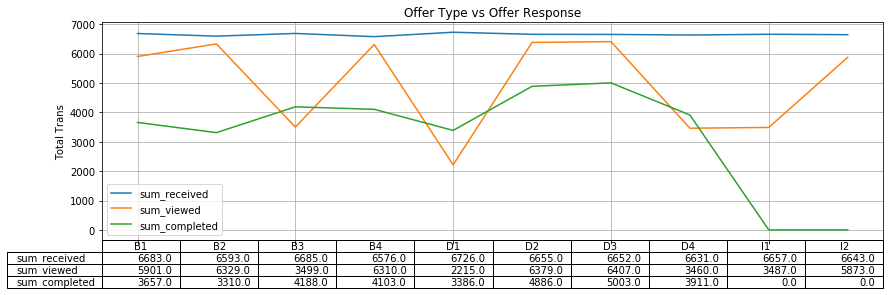

In [12]:
# Let's look at the offer response for different offer_type
df_stats = df_customer_mco.groupby('offer_label')\
                          .agg({'cnt_received':'sum', 'cnt_viewed':'sum', 'cnt_completed':'sum'})\
                          .rename(columns={'cnt_received':'sum_received',
                                            'cnt_viewed':'sum_viewed',
                                            'cnt_completed':'sum_completed'})

handle.plt_data(df_stats, kind='line', ylabel='Total Trans', color=None, title='Offer Type vs Offer Response')

1. Transactions are evently distributed across different offer types.  However the responses towards different offers are vary.
2. Informational offer type (I1 & I2):
    i. The customer doesn't need to complete anything to get the offer, hence Complete transactions=0.  
    ii.  However, I2 had more people viewed compared to I1.  One of the possible reason could be due to the effectiness of the offer distribution channel.
3. Bogo Offer Type (B1-B4):
    i. Offer B2 has the highest viewed rate but lowest completion rate due to higher difficulty level & shorter duration to complete it.  Same response pattern observed for Offer B1.
    ii. Offer B3 has lowest viewed rate but highest completion rate due to lower difficulty level and longer duration to complete it.
    iii. Another observation is Offer B3 had the lowest viewed rate due to it doesn't publish via social channel while others did.  This is an indication that Social channel is one of effective comm channel to promote Offer.
4. Discount Offer Type (D1-D4):
    i. D1 has the lowest viewed and completion rate compared to others in the same offer type category due to the highest difficulty level as well as lack of effective offer channel distribution.
    ii. D2 & D3 are the 2 top offers with highest viewed and completion rate among all despite of the higher difficulty level & low reward given.  Common themes observed are the offer distributed via all channels available as well as longer duration provided to complete the offer.
5. There are many more analysis can be done here but due to time constraint, I am going to stop here.  
6. In summary, based on the above analysis, it is observed that channels distribution, duration to complete the offer as well as offer difficulty level will impact customers' responses towards the offer received.
    


In [13]:
df_portfolio_clean.sort_values(by='offer_type')

,difficulty,duration,offer_id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web,offer_label
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,B1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,B2
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,B3
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,B4
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,D1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1,D2
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1,D3
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1,D4
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,I1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0,I2


### ii. Channel distributions impact to Offer Response vs Offer Type Analysis

In [14]:
# merge the customer offer summary with portfolio data frame
df_stats = df_customer_mco.merge(df_portfolio_clean, on='offer_label', how='left')

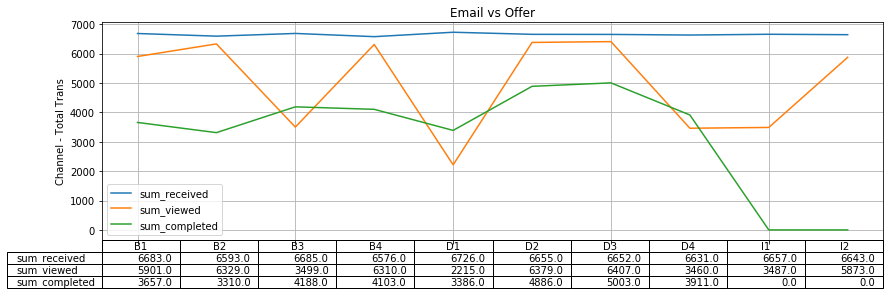

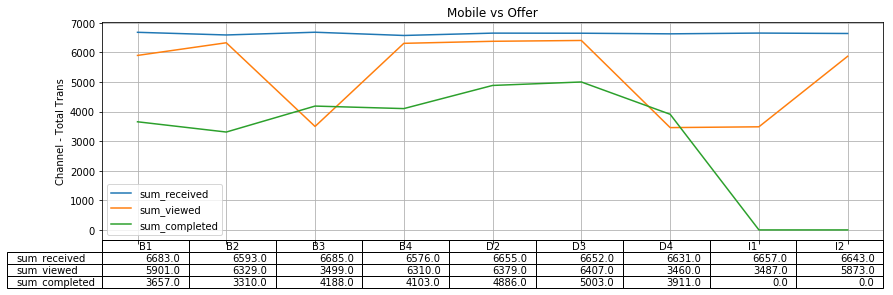

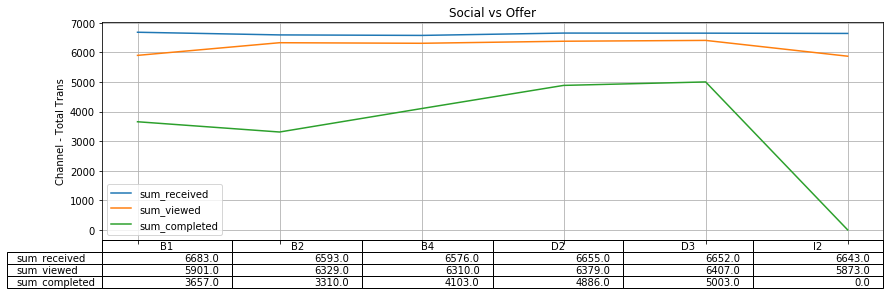

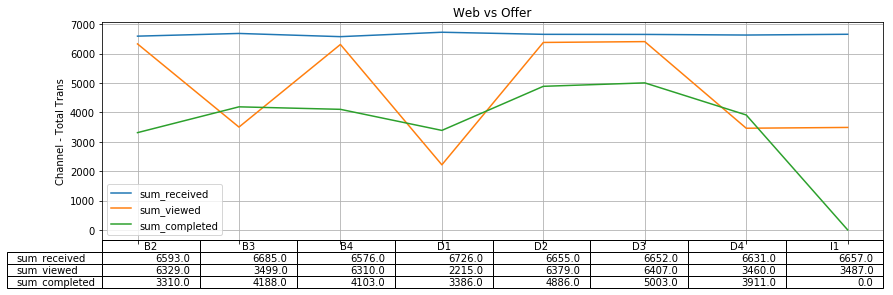

In [15]:
# Let's look at the offer response for different offer_type by channel

# Email
df_stats_ch = df_stats[df_stats['channel_email'] ==1].groupby('offer_label')\
                          .agg({'cnt_received':'sum', 'cnt_viewed':'sum', 'cnt_completed':'sum'})\
                          .rename(columns={'cnt_received':'sum_received',
                                            'cnt_viewed':'sum_viewed',
                                            'cnt_completed':'sum_completed'})
handle.plt_data(df_stats_ch, kind='line', ylabel='Channel - Total Trans', title='Email vs Offer', color=None)

# Mobile
df_stats_ch = df_stats[df_stats['channel_mobile'] ==1].groupby('offer_label')\
                          .agg({'cnt_received':'sum', 'cnt_viewed':'sum', 'cnt_completed':'sum'})\
                          .rename(columns={'cnt_received':'sum_received',
                                            'cnt_viewed':'sum_viewed',
                                            'cnt_completed':'sum_completed'})
handle.plt_data(df_stats_ch, kind='line', ylabel='Channel - Total Trans', title='Mobile vs Offer', color=None)

# Social
df_stats_ch = df_stats[df_stats['channel_social'] ==1].groupby('offer_label')\
                          .agg({'cnt_received':'sum', 'cnt_viewed':'sum', 'cnt_completed':'sum'})\
                          .rename(columns={'cnt_received':'sum_received',
                                            'cnt_viewed':'sum_viewed',
                                            'cnt_completed':'sum_completed'})
handle.plt_data(df_stats_ch, kind='line', ylabel='Channel - Total Trans', title='Social vs Offer', color=None)

# web
df_stats_ch = df_stats[df_stats['channel_web'] ==1].groupby('offer_label')\
                          .agg({'cnt_received':'sum', 'cnt_viewed':'sum', 'cnt_completed':'sum'})\
                          .rename(columns={'cnt_received':'sum_received',
                                            'cnt_viewed':'sum_viewed',
                                            'cnt_completed':'sum_completed'})
handle.plt_data(df_stats_ch, kind='line', ylabel='Channel - Total Trans', title='Web vs Offer', color=None)

1. There is variability in viewing rate for channels - Email, Mobile & Web.
2. However it is pretty consistent with high viewing rate for channel - Social.
3. The completion rate is vary mainly impacted by the type of Offers promoted.  However, as we know, by increasing chances of the offer view by customer, it will definitey help to increase the potential of completion rate as well as the product purchase.

# 3. Modelling - Recommendation Engines

## A. Create a Rank-Based Recommendation

First, let's create the Rank-Based Recommendation based on Top Offers with option to choose either by offer received, viewed or completed.

In [16]:
# return top offers based on the offer key passed
print('Offer received:\n',handle.get_top_offers(customer_id=None, df=df_portfolio_clean, dfmco=df_customer_mco, n=1, offer_key='received'))

print('\nOffer viewed:\n',handle.get_top_offers(customer_id=None, df=df_portfolio_clean, dfmco=df_customer_mco, n=1, offer_key='viewed'))

print('\nOffer completed:\n',handle.get_top_offers(customer_id=None, df=df_portfolio_clean, dfmco=df_customer_mco, n=1, offer_key='completed'))

Offer received:
    difficulty  duration                          offer_id offer_type  reward  \
4          20        10  0b1e1539f2cc45b7b9fa7c272da2e1d7   discount       5   

   channel_email  channel_mobile  channel_social  channel_web offer_label  
4              1               0               0            1          D1  

Offer viewed:
    difficulty  duration                          offer_id offer_type  reward  \
6          10        10  fafdcd668e3743c1bb461111dcafc2a4   discount       2   

   channel_email  channel_mobile  channel_social  channel_web offer_label  
6              1               1               1            1          D3  

Offer completed:
    difficulty  duration                          offer_id offer_type  reward  \
6          10        10  fafdcd668e3743c1bb461111dcafc2a4   discount       2   

   channel_email  channel_mobile  channel_social  channel_web offer_label  
6              1               1               1            1          D3  


We can use this recommendation method for new customer (Cold Start Problem) that we don't have any information (even customer id) to cross reference for the offer recommendation.

## B. Create customer clusters using KMeans

Segmentize the customers into different clusters as another way of recommendations options

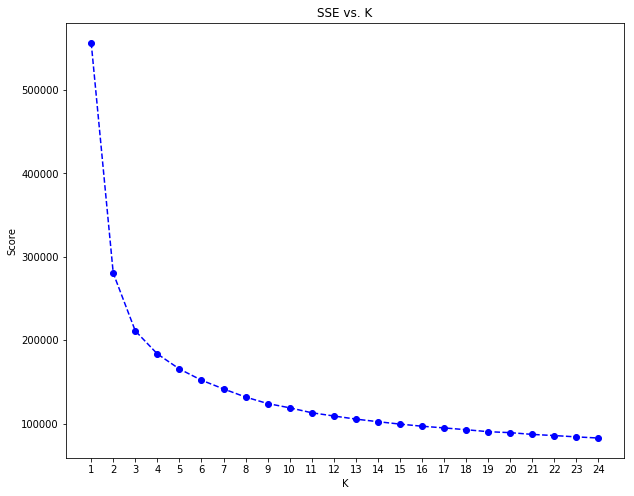

In [18]:
# create cluster for the customers
df_cust_mcot_sum['cluster'] = handle.create_cluster(dfmcot=df_cust_mcot_sum)

Based on the curve plot of "within-cluster sum of square(wss)" according to the number of clusters k above, 11 is a good bending point to consider as the optimum number of clusters to select in this case.

In [19]:
#creating a dataframe containing the column values of cluster demographic
df_cluster_stats = df_cust_mcot_sum.groupby('cluster', as_index = False).agg({
    'age_cat':lambda x:stats.mode(x)[0],
    'gender_cat': lambda x:stats.mode(x)[0],
    'income_cat': lambda x:stats.mode(x)[0],
    'cnt_received': 'mean',
    'cnt_viewed': 'mean',
    'cnt_completed': 'mean',
    'cnt_transaction': 'mean',
    'sum_amount': 'mean',
})

df_cluster_stats

,cluster,age_cat,gender_cat,income_cat,cnt_received,cnt_viewed,cnt_completed,cnt_transaction,sum_amount
0,1,4,1,4,4.586420,3.598765,3.216049,7.709877,861.873951
1,2,3,2,1,5.022556,4.114662,3.020677,22.349624,153.674098
2,3,4,1,4,3.669686,2.241115,2.056446,4.651568,112.314885
3,4,4,2,3,5.098420,4.357040,3.021552,4.712644,93.230589
4,5,4,1,3,5.098634,4.399090,4.113050,12.701821,253.289719
5,6,3,2,1,4.057775,2.404968,0.403888,4.032937,20.807343
6,7,4,1,4,4.789574,3.946437,3.603061,8.580583,179.677437
7,8,3,2,1,4.108765,2.833013,1.808061,11.690339,94.225240
8,9,4,2,3,4.525000,3.579687,0.680469,1.393750,23.542641
9,10,3,2,1,4.738547,3.644550,2.785940,16.784360,153.628586


Above stats described the characteristics of the 11 clusters created based on the customer-offer-transactions summarized data frame. 

In [20]:
df_cust_mcot_sum.groupby('cluster')['customer_id'].agg('count')

cluster
1      162
2      532
3     1435
4     1392
5     1318
6     1852
7     2091
8     1563
9     1280
10    1266
11    1934
Name: customer_id, dtype: int64

1. Looks like customers are not evenly distributed across the different clusters.  It is actually make sense in this case based on the analysis done earlier in Section #2 - Data Analysis.
2. Cluster 1 had the least population compare to others.  Based on the stats, it could be due to the high total amount spent per customer.  
3. Cluster 2 had the 2nd least population, potentially due to high # of transactions per customer.
4. Cluster 7 had the most customers grouped together.  Based on the analysis, it looks reasonable as the mode for Age_cat & Income_cat are 4 & 4 respectively which had the higher population as seen earlier in our data analysis 

## C. Create User-User Based Collaborative Filtering by Cluster

Recommend top offers based on the customers' responses within the same cluster

In [21]:
customer_id= 'a678040b34eb47e0ad23864c283dc8ef'

handle.get_top_offers(customer_id, df=df_portfolio_clean, dfpf=df_profile_clean, dfmco=df_customer_mco\
               , dfmcot=df_cust_mcot_sum, n=3, offer_key='completed')

,difficulty,duration,offer_id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web,offer_label
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,D1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1,D2
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1,D3


## D. Create User-Item Based Collaborative Filtering

In [33]:
# create the user-item matrix
arr_user_mat, arr_offer_mat, arr_user_ids, arr_offer_labels = handle.fit(dfo=df_customer_mco, offer_key='viewed'\
                                                                         , latent_features=20, learning_rate=0.01)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.188051
2 		 0.160607
3 		 0.158462
4 		 0.156367
5 		 0.154320
6 		 0.152319
7 		 0.150361
8 		 0.148445
9 		 0.146567
10 		 0.144725
11 		 0.142917
12 		 0.141141
13 		 0.139393
14 		 0.137671
15 		 0.135974
16 		 0.134298
17 		 0.132641
18 		 0.131000
19 		 0.129373
20 		 0.127757
21 		 0.126150
22 		 0.124550
23 		 0.122952
24 		 0.121356
25 		 0.119759
26 		 0.118158
27 		 0.116550
28 		 0.114934
29 		 0.113306
30 		 0.111666
31 		 0.110010
32 		 0.108337
33 		 0.106645
34 		 0.104931
35 		 0.103196
36 		 0.101437
37 		 0.099653
38 		 0.097845
39 		 0.096010
40 		 0.094149
41 		 0.092263
42 		 0.090351
43 		 0.088415
44 		 0.086456
45 		 0.084474
46 		 0.082473
47 		 0.080454
48 		 0.078419
49 		 0.076372
50 		 0.074314
51 		 0.072251
52 		 0.070184
53 		 0.068117
54 		 0.066054
55 		 0.063999
56 		 0.061956
57 		 0.059927
58 		 0.057917
59 		 0.055929
60 		 0.053966
61 		 0.052033
62 		 0.050131
63 		 0.048263
64 		 0

In [34]:
df_profile_clean.loc[df_profile_clean.gender == 'M'][500:510]

,age,became_member_on,gender,customer_id,income,complete_profile,gender_cat,age_cat,income_cat
1049,50,2015-08-06,M,8b704836fd074c569c86918c58fd5617,62000.0,1,2,3,3
1061,58,2017-09-13,M,b1a57282575b473b9d16c8b93057529b,77000.0,1,2,4,4
1063,77,2015-01-01,M,889aaae24e8a4df7a128f20029aa8422,58000.0,1,2,5,2
1067,39,2018-05-21,M,74e5b57030914e5e9e7ec1e7f89da357,64000.0,1,2,3,3
1068,61,2013-12-05,M,8101f91fe14b4311a1253873934a1255,34000.0,1,2,4,1
1072,63,2017-12-23,M,bae134fdf29e4734bb7165e0ce4e8297,34000.0,1,2,4,1
1073,28,2017-10-03,M,ae26bd07ecac4e6b80f1c78486b9f89c,67000.0,1,2,2,3
1074,46,2017-10-09,M,de8ea15f5f0545b6b45df1a7ae2dca11,32000.0,1,2,3,1
1076,70,2017-06-30,M,cc00d76372a14f439a9bf165169c287d,98000.0,1,2,4,5
1080,29,2017-10-15,M,3fa6a23cfb1b47a4a1bffd4a2e227f1c,67000.0,1,2,2,3


In [35]:
# make user-item base collaborative filtering recommendation 
customer_id='bae134fdf29e4734bb7165e0ce4e8297'
print(handle.make_recommendations(customer_id=customer_id, rec_num=3, user_mat=arr_user_mat, offer_mat=arr_offer_mat,\
                                  uids=arr_user_ids, oids=arr_offer_labels, dfmco=df_customer_mco))

['B4' 'D1' 'D4']


In [36]:
# predict the # transactions for the offer recommended
handle.predict_offer(customer_id=customer_id, offer_label='B4', uids=arr_user_ids, oids=arr_offer_labels,\
               user_mat=arr_user_mat, offer_mat=arr_offer_mat )

For customer bae134fdf29e4734bb7165e0ce4e8297 we predict 2 transactions for the offer B4.


2

# 4. Model Evaluation & Validation

A. Rank-Based Recommendation 
   1. This recommendation engine able to return top offers correctly (with highest # of transcripts either for offer received, viewed or completed as specified) when no customer_id is provided to address Cold Start problem where we don't have any information pertaining the new customer for Starbucks to begin with.

B. Customer Segment Clustering and User-User Based Collaborative Filtering by Cluster Recommendation
  1. As discussed and sample check in the Section 3B & 3C above, the algorithm is able to segment the customers into 11 clusters pretty well.  It able to recommend the top offers within the same customer cluster correctly. 

C. User-Item Based Collaborative Filtering Recommendation
  1. This recommendation engine able to recommend top offers for existing customers based on similar users matrix built using basic form of FunkSVD.
  2. It is also able to provide prediction how many responses would a customer react per offer recommended.  However we can't validate how good/accurate is the prediction as part of this project scope.
  
It is always a challenge to evaluate the effectiveness of the recommendation engine without putting it into the real production environment to collect the feedback of the customers' response towards the offer recommended.  We can run Online and Offline Testing for the recommendation engines outlined above.

Stabucks can run an A/B testing for a period of time.  In this case, 3 months probably will be a good testing windows as the different types of offers open duration ranging from 3-10 days.  This will enable us to collect the data based on multiple offers' cycles. 

For the A/B testing, Starbucks will divide the customers into 2 groups, control and experiment group respectively.  This can be achieved by assigning cookies in the app for differentiation.  The control group will receive the offer as-is today without the assistant from the recommendation engines above while the experiment group will.  Starbucks should monitor the differences in both invariant and evaluation metrics to ensure a successful testing.

    i. The invariant metrics to monitor are:
        - The # of customers assigned in control and experiment groups. Recommendation is close to 50:50 split.
        - The number of cookies assigned to each group during the testing.  We need to ensure that no population imbalance in our testing that could possible skewed our evaluation and validation results.

    ii. The evaluation metrics to monitor are:
        - Ratio of offers views/completed vs offer received for all offers type - If it is higher in experiment group, is an indication the recommendation engine is helpful in engaging the response from the customers.
        - The # of purchase transactions & total amount spend - If this is higher for experiment group as compared to control group, this can be another indicator of the effectiveness of the recommendation engines.

Another methods that can be considered in evaluating the effectiveness of the recommendation engines are the offline methods.  Starbucks can collect other metrics from the experiment group post recommendation engines implementation to evaluate the effectiveness of the new capabilities deployed. 

	i. Precision - How many customers like the offers that recommended.
	ii. Recall - How many customers got the offers that they like recommended to them.

Based on the metrics evaluated, we can analyzed further and continue to tune and improve the recommendation engines in case the result doesn't achieve the target set.

# 5. Conclusion

Although the data set looks pretty simple, but there are many different aspects and ways to analyze the data to gain different insights out of it.  Due to time constraint faced, I have to cut down my analysis to some basic scopes only that enable me to develop the simple recommendation engines for this project.  

Below are the areas that I would like further deep dive into in the future when times permitted:

    i. How the customer react to different type of offers by looking at the sequence of the transactions happen in time
    ii. Will there be any impact to the customer-offer-purchase transactions interaction in any day of a week
    iii. Interaction between characteristics of different offers type vs customers gender/age/income
    iv. From the data set, it is observed that Social channel is the most effective way to engage better offer response from customer however not all offers are distributed/marketed via this channel.  Worth of time to understand more why.
    v. try out different model like classification or regression to predict the customer response towards different type offers